In [1]:
import os, sys, re, pickle
from tqdm import tqdm
import os.path as osp

import pandas as pd
import numpy as np
from collections import Counter


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor

In [2]:
traindf_path = "~/INLG-shared-task/PreCogLTRC-HinglishEval-INLG-2022/dataset/traindf.json"
valdf_path = "~/INLG-shared-task/PreCogLTRC-HinglishEval-INLG-2022/dataset/valdf.json"

In [3]:
traindf = pd.read_json(traindf_path)
valdf = pd.read_json(valdf_path)


In [4]:
traindf.columns, traindf.shape

(Index(['index', 'English', 'Hindi', 'Hinglish', 'Average rating',
        'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
        'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
        'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
        'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
        'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
        'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
        'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
        'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
        'symcom_na_count', 'symcom_others'],
       dtype='object'),
 (2766, 38))

In [5]:
valdf.columns, valdf.shape

(Index(['index', 'English', 'Hindi', 'Hinglish', 'hum_gen', 'Hinglish_csnliop',
        'hum_gen_csnliop', 'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm',
        'hum_gen_lid', 'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
        'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
        'symcom_scores_sent', 'PRON_symcom', 'ADV_symcom', 'PART_symcom',
        'DET_symcom', 'NOUN_symcom', 'ADP_symcom', 'VERB_symcom', 'AUX_symcom',
        'ADJ_symcom', 'SCONJ_symcom', 'PROPN_symcom', 'CCONJ_symcom',
        'NUM_symcom', 'INTJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
        'symcom_na_count', 'symcom_others'],
       dtype='object'),
 (395, 36))

# columns MinMax scaling normalisation

In [6]:
def standarize_cols(df, cols_to_be_standardized, newcolnames):
    
    X = df[cols_to_be_standardized]
    coldata_numpy_reshaped = X.to_numpy()
    scale = StandardScaler().fit(coldata_numpy_reshaped)        
    transformed_coldata = scale.transform(coldata_numpy_reshaped)
    df = pd.concat([df, pd.DataFrame(transformed_coldata, columns = newcolnames)], axis=1)
    return df

def normalize_cols(df, cols_to_be_normalised, newcolnames):
    
    X = df[cols_to_be_normalised]
    coldata_numpy_reshaped = X.to_numpy()
    norm = MinMaxScaler().fit(coldata_numpy_reshaped)    
    transformed_coldata = norm.transform(coldata_numpy_reshaped)
    df = pd.concat([df, pd.DataFrame(transformed_coldata, columns = newcolnames)], axis=1)
    return df


In [7]:
def generate_colnames_withSuffix(colnames, suffix ):
    newcolnames = []
    for col in colnames:
        newcolnames.append(col+'_'+suffix)
        
    return newcolnames

cols_to_be_standardized = ['Hinglish_cmi_scores',
                           'Hinglish_burstiness_scores',
                           'Hinglish_sp_scores', 
                           'symcom_scores_sent',
                           'NOUN_symcom',
                           'AUX_symcom',
                           'CCONJ_symcom',
                           'ADP_symcom',
                           'NUM_symcom',
                           'PRON_symcom',
                           'PART_symcom',
                           'VERB_symcom',
                           'PROPN_symcom',
                           'SCONJ_symcom', 
                           'ADV_symcom',
                           'INTJ_symcom',
                           'DET_symcom',
                           'ADJ_symcom',
                           'symcom_+1_count',
                           'symcom_-1_count',
                           'symcom_na_count', 
                           'symcom_others'
                          ]

traindf_standard_all = normalize_cols(
                                    df = traindf, 
                                    cols_to_be_normalised = cols_to_be_standardized,
                                    newcolnames = generate_colnames_withSuffix(cols_to_be_standardized, 
                                                                     suffix = 'standardized'))

valdf_standard_all = normalize_cols(
                                    df = valdf, 
                                    cols_to_be_normalised = cols_to_be_standardized,
                                    newcolnames = generate_colnames_withSuffix(cols_to_be_standardized, 
                                                                     suffix = 'standardized'))




In [17]:
traindf_standard_all.columns

Index(['index', 'English', 'Hindi', 'Hinglish', 'Average rating',
       'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
       'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
       'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
       'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
       'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
       'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
       'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
       'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
       'symcom_na_count', 'symcom_others', 'Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized', 'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_stan

# Linear Regression

In [8]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Average rating"]

model = sm.OLS(y, X_imputed_data).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Average rating   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     14.95
Date:                Thu, 05 May 2022   Prob (F-statistic):           6.86e-51
Time:                        17:22:35   Log-Likelihood:                -5093.7
No. Observations:                2766   AIC:                         1.023e+04
Df Residuals:                    2744   BIC:                         1.036e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4323      0.207     -2.086      0.037      -0.839      -0.026
x2            -0.6985      0.247     -2.832      0.005      -1.182      -0.215
x3            -0.5189      0.568     -0.914      0.361      -1.632       0.594
x4             0.0876      0.236      0.371      0.711      -0.375       0.551
x5             0.6767      0.152      4.459      0.000       0.379       0.974
x6            -0.3686      0.258     -1.429      0.153      -0.875       0.137
x7             0.3801      0.200      1.898      0.058      -0.013       0.773
x8            -0.3724      0.239     -1.561      0.119      -0.840       0.095
x9            -0.6349      0.292     -2.177      0.030      -1.207      -0.063
x10           -0.3965      0.218     -1.821      0.069      -0.823       0.030
x11           -0.5467      0.346     -1.582      0.114      -1.224       0.131
x12           -0.8484      0.162     -5.236      0.000      -1.166      -0.531
x13            0.0864      0.182      0.475      0.635      -0.270       0.443
x14            1.1002      0.623      1.766      0.077      -0.121       2.322
x15            0.1240      0.186      0.666      0.506      -0.241       0.489
x16            0.4521      0.561      0.806      0.420      -0.647       1.551
x17           -0.5215      0.198     -2.630      0.009      -0.910      -0.133
x18            0.4764      0.126      3.775      0.000       0.229       0.724
x19            2.4531      0.632      3.884      0.000       1.215       3.692
x20            6.8720      0.382     17.974      0.000       6.122       7.622
x21            7.1801      0.346     20.736      0.000       6.501       7.859
x22            3.4884      0.530      6.584      0.000       2.449       4.527
==============================================================================
Omnibus:                      113.138   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.545
Skew:                          -0.521   Prob(JB):                     3.32e-28
Kurtosis:                       2.898   Cond. No.                         50.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
X_test = valdf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]

X_test_imputed_data = sim.transform(X_test.values)


predictions = model.predict(X_test_imputed_data)

print(predictions)

[7.72367966 7.25611928 7.59534325 8.27092481 8.04115035 8.03152276
 7.79015719 8.18182958 7.7491748  8.15335766 7.96115563 7.79243623
 7.98787927 8.05301394 8.35074987 8.58076587 8.09046664 8.23270498
 7.7082036  7.89769649 8.00664459 7.80830179 8.43871955 6.7369382
 8.00550666 8.01857482 7.85489869 8.13479472 8.55225542 8.26357656
 7.89524672 8.05550842 8.12152523 8.45850859 8.20581007 7.8662736
 8.15289094 7.76448913 7.89763385 7.66222091 8.1972876  8.13590462
 7.47554386 6.93192045 8.28816652 8.29637852 8.1576895  8.12978965
 7.32447733 8.09079482 7.77313057 8.00816427 8.19986355 8.30760543
 7.9275712  8.56325642 7.17911105 8.46180253 7.56755202 8.51923659
 7.88981949 8.2995073  7.76279733 8.01018149 8.28484042 8.18247716
 8.25554127 8.64957901 8.20214984 8.04617026 7.7760569  8.11836409
 7.76431529 7.73176561 7.89781799 8.30845445 7.85375075 8.02968614
 8.34788382 8.18112479 8.25411123 8.30093772 7.58773765 7.71922583
 8.26146494 7.74478939 7.74735673 8.11961063 7.60023816 8.014583

In [14]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Disagreement"]

model = sm.OLS(y, X_imputed_data).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Disagreement   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     10.81
Date:                Thu, 05 May 2022   Prob (F-statistic):           6.79e-35
Time:                        17:23:50   Log-Likelihood:                -5568.4
No. Observations:                2766   AIC:                         1.118e+04
Df Residuals:                    2744   BIC:                         1.131e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0221      0.246      0.090      0.928      -0.460       0.505
x2            -0.1409      0.293     -0.481      0.630      -0.715       0.433
x3            -0.1924      0.674     -0.286      0.775      -1.514       1.129
x4             0.4496      0.280      1.604      0.109      -0.100       0.999
x5            -1.3302      0.180     -7.384      0.000      -1.683      -0.977
x6            -0.1778      0.306     -0.580      0.562      -0.778       0.423
x7            -0.7383      0.238     -3.105      0.002      -1.204      -0.272
x8             0.2958      0.283      1.044      0.297      -0.260       0.851
x9             0.2720      0.346      0.786      0.432      -0.407       0.951
x10           -0.3807      0.259     -1.473      0.141      -0.888       0.126
x11            0.4622      0.410      1.127      0.260      -0.342       1.267
x12            0.0755      0.192      0.392      0.695      -0.302       0.453
x13           -0.0604      0.216     -0.280      0.780      -0.484       0.363
x14           -0.7916      0.740     -1.070      0.285      -2.242       0.659
x15           -0.1454      0.221     -0.657      0.511      -0.579       0.288
x16           -0.3233      0.666     -0.486      0.627      -1.628       0.982
x17           -0.0631      0.235     -0.268      0.789      -0.525       0.398
x18           -0.6410      0.150     -4.278      0.000      -0.935      -0.347
x19            2.5583      0.750      3.412      0.001       1.088       4.029
x20            3.2525      0.454      7.165      0.000       2.362       4.143
x21            2.6236      0.411      6.382      0.000       1.817       3.430
x22            2.4992      0.629      3.973      0.000       1.266       3.733
==============================================================================
Omnibus:                      285.751   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              378.283
Skew:                           0.870   Prob(JB):                     7.19e-83
Kurtosis:                       3.507   Cond. No.                         50.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/prashantk/miniconda3/envs/cm/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<AxesSubplot:>

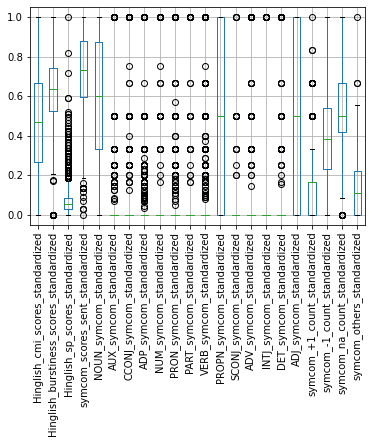

In [16]:
subdf = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized', 'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]

for col in subdf.columns:
    subdf[col] = pd.to_numeric(traindf_standard_all[col],errors='coerce')

subdf.boxplot(rot=90)

In [25]:
traindf.columns

Index(['level_0', 'English', 'Hindi', 'Hinglish', 'Average rating',
       'Disagreement', 'hum_gen', 'Hinglish_csnliop', 'hum_gen_csnliop',
       'Hinglish_norm', 'Hinglish_lid', 'hum_gen_norm', 'hum_gen_lid',
       'Hinglish_pos', 'hum_gen_pos', 'Hinglish_cmi_scores',
       'Hinglish_burstiness_scores', 'Hinglish_sp_scores', 'symcom_scores_pos',
       'symcom_scores_sent', 'NOUN_symcom', 'AUX_symcom', 'CCONJ_symcom',
       'ADP_symcom', 'NUM_symcom', 'PRON_symcom', 'PART_symcom', 'VERB_symcom',
       'PROPN_symcom', 'SCONJ_symcom', 'ADV_symcom', 'INTJ_symcom',
       'DET_symcom', 'ADJ_symcom', 'symcom_+1_count', 'symcom_-1_count',
       'symcom_na_count', 'symcom_others'],
      dtype='object')

# MLP Regressor

In [18]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Average rating"]


regr = MLPRegressor(random_state=1, max_iter=10000, verbose = True).fit(X_imputed_data, y)


X_test = valdf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]

X_test_imputed = sim.transform(X_test)

predictions_test = regr.predict(X_test_imputed)

predictions_test_round = [round(el) for el in predictions_test]

Iteration 1, loss = 23.60918679
Iteration 2, loss = 19.05109922
Iteration 3, loss = 14.64669927
Iteration 4, loss = 10.17083808
Iteration 5, loss = 6.17558910
Iteration 6, loss = 3.43105970
Iteration 7, loss = 2.11934624
Iteration 8, loss = 1.77151856
Iteration 9, loss = 1.72364496
Iteration 10, loss = 1.68343702
Iteration 11, loss = 1.64539143
Iteration 12, loss = 1.61163246
Iteration 13, loss = 1.57963281
Iteration 14, loss = 1.54789485
Iteration 15, loss = 1.51656641
Iteration 16, loss = 1.48671901
Iteration 17, loss = 1.46038242
Iteration 18, loss = 1.43472935
Iteration 19, loss = 1.41238740
Iteration 20, loss = 1.39133088
Iteration 21, loss = 1.37316617
Iteration 22, loss = 1.35558232
Iteration 23, loss = 1.34019361
Iteration 24, loss = 1.32296191
Iteration 25, loss = 1.30774578
Iteration 26, loss = 1.29359605
Iteration 27, loss = 1.28103213
Iteration 28, loss = 1.26976589
Iteration 29, loss = 1.25941492
Iteration 30, loss = 1.25057575
Iteration 31, loss = 1.24384604
Iteration 32,

/home/prashantk/miniconda3/envs/cm/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [71]:
with open('test_predictions_avg_rating.txt','w') as f:
    for el in predictions_test_round:
        f.write(str(el)+"\n")

In [19]:
X = traindf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]


sim = SimpleImputer(missing_values=np.nan, strategy='mean')

X_imputed_data = sim.fit_transform(X.values)

y = traindf_standard_all["Disagreement"]


regr = MLPRegressor(random_state=1, max_iter=10000, verbose = True).fit(X_imputed_data, y)


X_test = valdf_standard_all[['Hinglish_cmi_scores_standardized',
       'Hinglish_burstiness_scores_standardized',
       'Hinglish_sp_scores_standardized',
        'symcom_scores_sent_standardized',
       'NOUN_symcom_standardized', 'AUX_symcom_standardized',
       'CCONJ_symcom_standardized', 'ADP_symcom_standardized',
       'NUM_symcom_standardized', 'PRON_symcom_standardized',
       'PART_symcom_standardized', 'VERB_symcom_standardized',
       'PROPN_symcom_standardized', 'SCONJ_symcom_standardized',
       'ADV_symcom_standardized', 'INTJ_symcom_standardized',
       'DET_symcom_standardized', 'ADJ_symcom_standardized',
       'symcom_+1_count_standardized', 'symcom_-1_count_standardized',
       'symcom_na_count_standardized', 'symcom_others_standardized']]

X_test_imputed = sim.transform(X_test)

predictions_test = regr.predict(X_test_imputed)

predictions_test_round = [round(el) for el in predictions_test]

Iteration 1, loss = 3.47793591
Iteration 2, loss = 2.47440369
Iteration 3, loss = 1.94562446
Iteration 4, loss = 1.82335902
Iteration 5, loss = 1.79500755
Iteration 6, loss = 1.76364635
Iteration 7, loss = 1.74024492
Iteration 8, loss = 1.72169934
Iteration 9, loss = 1.70512668
Iteration 10, loss = 1.69080275
Iteration 11, loss = 1.68103616
Iteration 12, loss = 1.67129524
Iteration 13, loss = 1.66529421
Iteration 14, loss = 1.65874266
Iteration 15, loss = 1.65398973
Iteration 16, loss = 1.65055714
Iteration 17, loss = 1.64668561
Iteration 18, loss = 1.64520753
Iteration 19, loss = 1.64172245
Iteration 20, loss = 1.63922540
Iteration 21, loss = 1.63735676
Iteration 22, loss = 1.63481209
Iteration 23, loss = 1.63306696
Iteration 24, loss = 1.63119629
Iteration 25, loss = 1.63032205
Iteration 26, loss = 1.62957608
Iteration 27, loss = 1.62637102
Iteration 28, loss = 1.62427450
Iteration 29, loss = 1.62189257
Iteration 30, loss = 1.62111039
Iteration 31, loss = 1.61996056
Iteration 32, los

/home/prashantk/miniconda3/envs/cm/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [76]:
with open('test_predictions_avg_rating.txt','a') as f:
    for el in predictions_test_round:
        f.write(str(el)+"\n")

In [77]:
len(open('test_predictions_avg_rating.txt','r').readlines())

790